In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.0.csv.gz")    

In [5]:
len(energy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   building_id    8784 non-null   int64  
 1   meter          8784 non-null   int64  
 2   timestamp      8784 non-null   object 
 3   meter_reading  8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [6]:
energy = energy[energy['meter_reading'] > 0]

In [7]:
len(energy)

5411

In [8]:
energy['timestamp'] = pd.to_datetime(energy['timestamp'])

<ipython-input-8-a25c08a0f2e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy['timestamp'] = pd.to_datetime(energy['timestamp'])


In [9]:
energy['hour'] = energy['timestamp'].dt.hour

<ipython-input-9-2a5d0cdd1941>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy['hour'] = energy['timestamp'].dt.hour


In [10]:
energy.head()

,building_id,meter,timestamp,meter_reading,hour
704,0,0,2016-01-30 08:00:00,43.6839,8
725,0,0,2016-01-31 05:00:00,37.5408,5
737,0,0,2016-01-31 17:00:00,52.5571,17
2366,0,0,2016-04-08 14:00:00,59.3827,14
2923,0,0,2016-05-01 19:00:00,448.0000,19


In [11]:
X_train,X_test = train_test_split(energy,test_size=0.2)

In [12]:
len(X_train)

4328

In [13]:
energy_train_hours = X_train.groupby('hour')

In [14]:
energy_train_averages = pd.DataFrame({'Среднее':energy_train_hours.mean()['meter_reading'],
                                     'Медиана':energy_train_hours.median()['meter_reading']
                                     })

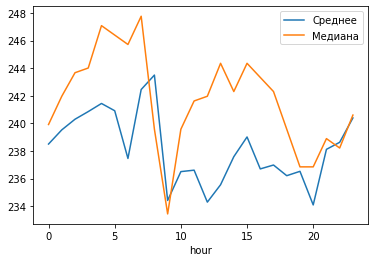

In [15]:
energy_train_averages.plot()

In [16]:
def calculate_model(x):
    meter_reading_log = np.log(x.meter_reading + 1)
    meter_reading_mean = np.log(energy_train_averages['Среднее'][x.hour] + 1)
    meter_reading_median = np.log(energy_train_averages['Медиана'][x.hour] + 1)
    x['meter_reading_mean_q'] = (meter_reading_log - meter_reading_mean) ** 2
    x['meter_reading_median_q'] = (meter_reading_log - meter_reading_median) ** 2
    x['meter_reading_zero_q'] = (meter_reading_log) ** 2
    return x

In [17]:
X_test = X_test.apply(calculate_model,axis=1,result_type='expand')

In [18]:
X_test.head()

,building_id,meter,timestamp,meter_reading,hour,meter_reading_mean_q,meter_reading_median_q,meter_reading_zero_q
8123,0,0,2016-12-04 11:00:00,180.196,11,0.073465,0.085230,27.035625
4261,0,0,2016-06-26 13:00:00,243.674,13,0.001140,0.000008,30.249194
4598,0,0,2016-07-10 14:00:00,303.739,14,0.059892,0.050681,32.712173
8175,0,0,2016-12-06 15:00:00,269.611,15,0.014394,0.009598,31.367643
5163,0,0,2016-08-03 03:00:00,308.517,3,0.060845,0.054612,32.890374


In [19]:
energy_median_rmsle = np.sqrt(X_test['meter_reading_median_q'].sum() / len(X_test))
energy_mean_rmsle = np.sqrt(X_test['meter_reading_mean_q'].sum() / len(X_test))
energy_zero_rmsle = np.sqrt(X_test['meter_reading_zero_q'].sum() / len(X_test))

In [20]:
print('Качество среднего: ',energy_mean_rmsle)
print('Качество медианы: ',energy_median_rmsle)
print('Качество нуля: ',energy_zero_rmsle)

Качество среднего:  0.26080927063261977
Качество медианы:  0.2638575505642107
Качество нуля:  5.445904266802308
